In [368]:
def intersect_trop_lines(first,second):
    a = first[0]
    b = first[1]
    c = second[0]
    d = second[1]
    #anchored at (c,d)
    if a>c and b>d and a>b: #1
        return [c+b,d+b]
    if a>c and b>d and a<b: #2
        return [c+a,d+a]
    if a>c and b>d and a==b:
        return [c+b-d,b]
    if a<c and b>d: #3
        return [a,d]
    if a<c and b<d and a<b: #4
        return [a+d-b,d]
    if a<c and b<d and a>b: #5
        return [c,b+c-a]
    if a<c and b<d and a==b:
        return [c,b+c-a]
    if a>c and d>b: #6
        return [c,b]
    #anchored at (a,b)
    if c>a and d>b and c>d: #1
        return [a+d,b+d]
    if c>a and d>b and c<d: #2
        return [a+c,b+c]
    if c>a and d>b and c==d:
        return [a+d-b,d]
    if c<a and d>b: #3
        return [c,b]
    if c<a and d<b and c<d: #4
        return [c+b-d,b]
    if c<a and d<b and c>d: #5
        return [a,d+a-c]
    if c<a and d<b and c==d:
        return [a,d+a-c]
    if c>a and b>d: #6
        return [a,d]
    
    
def compute_pseudovertices(vertices):
    pseudovertices = copy(vertices)
    edges = []
    for pair in Subsets(range(len(vertices)),2):
        if intersect_trop_lines(vertices[pair[0]],vertices[pair[1]]):
            pseudovertices.append(intersect_trop_lines(vertices[pair[0]],vertices[pair[1]]))
            index = len(pseudovertices)-1
            edges.append([pair[0],index])
            edges.append([pair[1],index])
        else:
            edges.append(list(pair))
    return {'pseudo': pseudovertices, 'edges': edges, 'vertices': vertices}


def tangent_cone(polytron, vertex_index):
    
    def primitive_vector_in_edge_direction(direction):
        x = direction[0]
        y = direction[1]
        if x==0 and y>0:
            primitive = [ 0, 1]
        elif x==0 and y<0:
            primitive = [ 0,-1]
        elif x>0 and y>0:
            primitive = [ 1, 1]
        elif x>0 and y==0:
            primitive = [ 1, 0]
        elif x<0 and y==0:
            primitive = [-1, 0]
        elif x<0 and y<0:
            primitive = [-1,-1]
        else:
            print 'not assigned'
        return primitive
    
    ##compute the generating function of the tangent cone at the given vertex
    vertex = polytron['pseudo'][vertex_index]
    
    
    #find neighbours of vertex
    incident_edges_index = [edge for edge in polytron["edges"] if vertex_index in edge]
    neighbours_index = []
    for edge_index in incident_edges_index:
        for index in edge_index:
            if index==vertex_index:
                continue
            else:
                neighbours_index.append(index)    
    neighbours = [ polytron['pseudo'][index] for index in neighbours_index ]
    
    #compute edge-directions
    edge_directions = [ [neighbour[0]-vertex[0],neighbour[1]-vertex[1]] for neighbour in neighbours ]
    
    primitives=[]
    #find primitive vector in edge-direction
    for direction in edge_directions:
        primitives.append(primitive_vector_in_edge_direction(direction))
    
    
    t1, t2, n = var('t1, t2, n')
    return ( t1^(n*vertex[0])* t2^(n*vertex[1]) )  / ( (1 - t1^primitives[0][0] * t2^primitives[0][1]) * (1 - t1^primitives[1][0] * t2^primitives[1][1])  )

def gen_fct(polytron):
    #for vertex_index in range(len(polytron["pseudo"])):
        #print tangent_cone(polytron,vertex_index)  
    return sum([tangent_cone(polytron,vertex_index) for vertex_index in range(len(polytron["pseudo"]))])

def ehrhart(polytron,evaluation):
    solutions = [gen_fct(polytron)(a=evaluation[0],b=evaluation[1]).factor()(n=k).factor()(t1=1,t2=1) for k in range(1,4)]
    mat = matrix([ [1,1,1],
                   [4,2,1],
                   [9,3,1] ])
    coeffs = mat.solve_right(vector(solutions))
    t = var('t')
    return sum(coeffs[i]*t^(2-i) for i in range(3))
        


In [369]:
a, b = var('a, b')
forget(assumptions())
assume( a>-1, -a-3<b, -b - 2<0)

vertices = [[b,1],[-a-3,-a],[b,-a]]
polytron = compute_pseudovertices(vertices)
#print polytron

#print gen_fct(polytron).numerator_denominator() 
generating_f = gen_fct(polytron).factor()
print generating_f
ehrhart(polytron,[0,0])

(t1^2*t1^(a*n)*t1^(b*n)*t1^(3*n)*t1^(2*n)*t2^2*t2^(a*n)*t2^n - t1*t1^(a*n)*t1^(b*n)*t1^(3*n)*t1^(2*n)*t2*t2^(a*n)*t2^n - t1^2*t1^(a*n)*t1^(b*n)*t1^(3*n)*t1^(2*n)*t2 - t1*t1^(a*n)*t1^(3*n)*t2^2*t2^(a*n)*t2^n + t1*t1^(a*n)*t1^(3*n)*t2*t2^(a*n)*t2^n + t1*t1^(a*n)*t1^(b*n)*t1^(3*n)*t1^(2*n) + t1^(2*n)*t2 - t1^(2*n))/((t1*t2 - 1)*(t1 - 1)*t1^((a + 3)*n)*t1^(2*n)*(t2 - 1)*t2^(a*n))


5/2*t^2 + 7/2*t + 1

In [362]:
#substitute all variables by (1-t)
t = var('t')
for j in range(1,3):
     generating_f = generating_f.subs({var('t'+str(j)):1-t})
    #generating_f = generating_f.subs({var('t'+str(j)):1-j*t})
print generating_f

((t - 1)^4*(-t + 1)^(2*a*n)*(-t + 1)^(b*n)*(-t + 1)^(3*n)*(-t + 1)^(2*n)*(-t + 1)^n + (t - 1)^3*(-t + 1)^(a*n)*(-t + 1)^(b*n)*(-t + 1)^(3*n)*(-t + 1)^(2*n) - (t - 1)^2*(-t + 1)^(2*a*n)*(-t + 1)^(b*n)*(-t + 1)^(3*n)*(-t + 1)^(2*n)*(-t + 1)^n + (t - 1)^3*(-t + 1)^(2*a*n)*(-t + 1)^(3*n)*(-t + 1)^n - (t - 1)*(-t + 1)^(a*n)*(-t + 1)^(b*n)*(-t + 1)^(3*n)*(-t + 1)^(2*n) + (t - 1)^2*(-t + 1)^(2*a*n)*(-t + 1)^(3*n)*(-t + 1)^n - (t - 1)*(-t + 1)^(2*n) - (-t + 1)^(2*n))/(((t - 1)^2 - 1)*t^2*(-t + 1)^((a + 3)*n)*(-t + 1)^(a*n)*(-t + 1)^(2*n))


In [363]:
#l'hopital
p = generating_f.numerator()
q = generating_f.denominator()
alpha = 0
p_deriv= p
q_deriv = q
while true:
    p_deriv = p_deriv.derivative(t)
    q_deriv = q_deriv.derivative(t)
    alpha += 1
    if not (p_deriv(t=0)==0 or q_deriv(t)==0):
        break
result = p_deriv(t=0)/q_deriv(t=0)
print result.simplify_full()

1/2*(a^2 + 2*(a + 1)*b + 6*a + 5)*n^2 + 1/2*(3*a + 2*b + 7)*n + 1


In [364]:
result(a=1,b=0).simplify_full()

6*n^2 + 5*n + 1

Making the Polyhedral Subdivision of $\mathbb R^d$  for 6 variables

The Setup: 

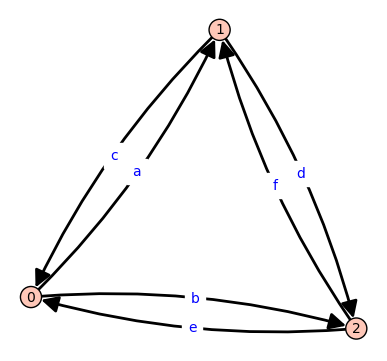

In [10]:
a,b,c,d,e,f = var('a,b,c,d,e,f')
D = matrix([[0,a,b],[c,0,d],[e,f,0]])
DG = DiGraph(D,weighted = True)
DG.show(edge_labels = True)

Here is the Kleene star of D:
D_Star = $
\begin{pmatrix}
min(0,a+c,b+e) & min(a,a,b+f)   & min(b,a+d,b) \\
min(c,c,d+e)   & min(a+c,0,d+f) & min(c+b,d,d) \\
min(e,f+c,e)   & min(a+e,f,f)   & min(e+b,d+f,0)
\end{pmatrix}$

In [27]:
#(1,1)
H1  = Polyhedron(eqns=[[0,1,0,1,0,0,0]],ieqs=[[0,-1,1,-1,0,1,0]])
H2  = Polyhedron(eqns=[[0,0,1,0,0,1,0]],ieqs=[[0,1,-1,1,0,-1,0]])
#(1,2)
H3  = Polyhedron(ieqs=[[0,-1,1,0,0,0,1]])
#(1,3)
H4  = Polyhedron(ieqs=[[0,1,-1,0,1,0,0]])
#(2,1)
H5  = Polyhedron(ieqs=[[0,0,0,-1,1,1,0]])
#(2,2)
H6  = Polyhedron(eqns=[[0,1,0,1,0,0,0]],ieqs=[[0,0,0,0,1,0,1]])
H7  = Polyhedron(eqns=[[0,0,0,0,1,0,1]],ieqs=[[0,1,0,1,0,0,0]])
#(2,3)
H8  = Polyhedron(ieqs=[[0,0,1,1,-1,0,0]])
#(3,1)
H9  = Polyhedron(ieqs=[[0,0,0,1,0,-1,1]])
#(3,2)
H10 = Polyhedron(ieqs=[[0,1,0,0,0,1,-1]])
#(3,3)
H11 = Polyhedron(eqns=[[0,0,1,0,0,1,0]],ieqs=[[0,0,0,0,1,0,1]])
H12 = Polyhedron(eqns=[[0,0,0,0,1,0,1]],ieqs=[[0,0,1,0,0,1,0]])

Redoing the Hyperplanes as regions

In [99]:
#(1,1)
R1   = Polyhedron(ieqs = [[0,-1,1,-1,0,1,0],[0,-1,0,-1,0,0,0]])
R2   = Polyhedron(ieqs = [[0,1,0,1,0,0,0],[0,0,1,0,0,1,0]])
R3   = Polyhedron(ieqs = [[0,0,-1,0,0,-1,0],[0,1,-1,1,0,-1,0]])
F11  = [R1,R2,R3]
#(1,2)
R4   = Polyhedron(ieqs = [[0,-1,1,0,0,0,1]])
R5   = Polyhedron(ieqs = [[0,1,-1,0,0,0,-1]])
F12  = [R4,R5]
#(1,3)
R6   = Polyhedron(ieqs = [[0,1,-1,0,1,0,0]])
R7   = Polyhedron(ieqs = [[0,-1,1,0,-1,0,0]])
F13  = [R6,R7]
#(2,1)
R8   = Polyhedron(ieqs = [[0,0,0,-1,1,1,0]])
R9   = Polyhedron(ieqs = [[0,0,0,1,-1,-1,0]])
F21  = [R8,R9]
#(2,2)
R10  = Polyhedron(ieqs = [[0,-1,0,-1,1,0,1],[0,-1,0,-1,0,0,0]])
R11  = Polyhedron(ieqs = [[0,0,0,0,1,0,1],[0,1,0,1,0,0,0]])
R12  = Polyhedron(ieqs = [[0,0,0,0,-1,0,-1],[0,1,0,1,-1,0,-1]])
F22  = [R10,R11,R12]
#(2,3)
R13  = Polyhedron(ieqs = [[0,0,1,1,-1,0,0]])
R14  = Polyhedron(ieqs = [[0,0,-1,-1,1,0,0]])
F23  = [R13,R14]
#(3,1)
R15  = Polyhedron(ieqs = [[0,0,0,1,0,-1,1]])
R16  = Polyhedron(ieqs = [[0,0,0,-1,0,1,-1]])
F31  = [R15,R16]
#(3,2)
R17  = Polyhedron(ieqs = [[0,1,0,0,0,1,-1]])
R18  = Polyhedron(ieqs = [[0,-1,0,0,0,-1,1]])
F32  = [R17,R18]
#(3,3)
R19  = Polyhedron(ieqs = [[0,0,-1,0,1,-1,1],[0,0,-1,0,0,-1,0]])
R20  = Polyhedron(ieqs = [[0,0,1,0,0,1,0],[0,0,0,0,1,0,1]])
R21  = Polyhedron(ieqs = [[0,0,1,0,-1,1,-1],[0,0,0,0,-1,0,-1]])
F33  = [R19,R20,R21]

Find the feasible, full dimensional regions:

In [115]:
def regions_of_complex(polyhedral_complex):
    r"""
    Returns the feasible regions of the ``polyhedral_complex``.
    Follows the method of regions in the hyperplane arrangements.
    
    INPUT: 
    
    - ``polyhedral_complex`` -- list. A list of polyhedron objects
    
    OUTPUT:
    
    A tuple of regions.
    """
    R = polyhedral_complex[0][0].base_ring()
    universe = Polyhedron(eqns = [[0] + [0]*6],base_ring = R)
    regions = [universe]
    for fan in polyhedral_complex:
        subdivided = []
        for region in regions:
            for cone in fan:
                part = region.intersection(cone)
                if part.dim()==6:
                    subdivided.append(part)
        regions = subdivided
    return tuple(regions)

Test it on the fans

In [116]:
six_variables_complex = [F11,F12,F13,F21,F22,F23,F31,F32,F33]
regions = regions_of_complex(six_variables_complex)


In [117]:
len(regions)

117

Discard the infeasible regions

In [266]:
def feasible_regions(initial_regions):
    r"""
    From the regions of a polyhedral complex, return the feasible regions.
    
    INPUT:
    
    -  ``initial_regions`` -- tuple of polyhedron objects. 
    
    OUTPUT:
    
    tuple of polyhedron objects representiing the feasible regions.
    """
    symbols_vec = vector([0,a,b,c,d,e,f])
    final_regions = list(initial_regions)
    for region in initial_regions:
        forget()
        assume(a,b,c,d,e,f,'integer')
        for ineq in region.inequalities_list():
            new_ineq = symbols_vec.dot_product(vector(ineq))
            assume(new_ineq > 0)
        if a+c < 0 or b+e < 0 or d+f < 0:
            final_regions.remove(region)
    return final_regions

In [267]:
feas_regs = feasible_regions(regions)

In [268]:
len(feas_regs)

63

In [118]:
first_region= regions[0]
first_region.inequalities_list()

[[0, 1, -1, 0, 1, 0, 0],
 [0, -1, 1, -1, 0, 1, 0],
 [0, 0, -1, 0, 0, -1, 0],
 [0, 0, 0, 1, 0, -1, 1]]

Try to get the Ehrhart polynomial for ``first_region``
These inequalities imply the following kleene star:
D_star_one = 
$\begin{pmatrix}
a+c & a & b \\
c & a+c & c+b \\
e  & a + e & b+e
\end{pmatrix}$

In [355]:
def tropical_vertices_from_region(region):
    r"""
    Return the symbolic tropical vertices corresponding to 
    a certain region. 
    
    INPUT:
    
    - ``region`` -- a polyhedron object. 
    
    OUTPUT:
    
    A list of the tropical vertices (already in the plane). 
    """
    forget()
    symbols_vec = vector([0,a,b,c,d,e,f])
    assume(a,b,c,d,e,f,'integer')
    for ineq in region.inequalities_list():
        new_ineq = symbols_vec.dot_product(vector(ineq))
        assume(new_ineq > 0)
    Kleene = matrix([[min(min(0, a+c),min(a+c,b+e)), min(a,a,b+f)  , min(b,a+d,b)],
                     [min(c,c,d+e)  , min(a+c,0,d+f), min(c+b,d,d)],
                     [min(e,f+c,e)  , min(a+e,f,f)  , min(e+b,d+f,0)]])
    
    #subtract the first entry
    L = list()
    for i in range(len(Kleene.rows())):
        new_row = list()
        j = Kleene.row(i)[0]
        for k in range(1,len(Kleene.row(i))):
            new_row.append(Kleene.row(i)[k] - j)
        L.append(new_row)
    return L
    
    


In [383]:
verts = tropical_vertices_from_region(feas_regs[38])
verts


[[b + f, b], [a + c - d - e, b + c - d - e], [a, -e]]

In [384]:
polytron = compute_pseudovertices(verts)

In [385]:
polytron

{'edges': [[0, 1], [0, 3], [2, 3], [1, 2]],
 'pseudo': [[b + f, b], [a + c - d - e, b + c - d - e], [a, -e], [b + f, -e]],
 'vertices': [[b + f, b], [a + c - d - e, b + c - d - e], [a, -e]]}

In [373]:
generating_f = gen_fct(polytron).factor()

not assigned


UnboundLocalError: local variable 'primitive' referenced before assignment